# Basic Overview
The idea here is to have a minimalized model with sex,pclass and age (using  xgboost) and fine tune the same
(and see where we get !)

Admittedly, this may not get us much with respect to score, but will be great learning opportunity(and foundation for future projects)

Comments/criticisms/appreciations are greatly accepted and appreciated. Do not be shy and send me an email at babinu@gmail.com !

Source of data : https://www.kaggle.com/c/titanic/data

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
# Ha
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test_data_processed_correct.csv")

In [5]:
train_data['Sex']

0        male
1      female
2      female
3      female
4        male
5        male
6        male
7        male
8      female
9      female
10     female
11     female
12       male
13       male
14     female
15     female
16       male
17       male
18     female
19     female
20       male
21       male
22     female
23       male
24     female
25     female
26       male
27       male
28     female
29       male
        ...  
861      male
862    female
863    female
864      male
865    female
866    female
867      male
868      male
869      male
870      male
871    female
872      male
873      male
874    female
875    female
876      male
877      male
878      male
879    female
880    female
881      male
882    female
883      male
884      male
885    female
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object

In [6]:
test_data.Survived.unique()

array([0., 1.])

Since XGBoost uses only numeric predictors, and we do not want to increase dimensionality, we will go with numeric encoding for sex and plcass variables for now.

In [7]:
train_data.loc[(train_data['Sex'] == 'male'), 'Sex'] = 1
train_data.loc[(train_data['Sex'] == 'female'), 'Sex'] = 0

test_data.loc[(test_data['Sex'] == 'male'), 'Sex'] = 1
test_data.loc[(test_data['Sex'] == 'female'), 'Sex'] = 0


In [8]:
# Add a column called Predictions in training data, which will become handy while doing
# cross validation.
train_data['Predictions'] = -1

In [9]:
from sklearn.preprocessing import Imputer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [10]:
def get_train_test_data(train_data,
                        X_columns=['Sex', 'Pclass', 'Age'], 
                        Y_columns=['Survived']):
    # Simple training and testing
    X = train_data[X_columns]
    Y = train_data[Y_columns]

    X_one_hot = pd.get_dummies(X)

    # Do imputation on relevant columns.
    X_train, X_test, Y_train, Y_test = train_test_split(X_one_hot, Y, random_state=0)

    return (X_train, X_test, Y_train, Y_test, X_one_hot, Y)


In [11]:
def create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test, n_estimators=100, 
                                            learning_rate=0.1):
    # Rewrite everything as a pipeline
    my_pipeline = make_pipeline(Imputer(), 
                                XGBClassifier(seed=1, n_estimators=n_estimators, learning_rate=learning_rate))
    my_pipeline.fit(X_train, Y_train.values.ravel())
    predictions = my_pipeline.predict(X_test)
    #predictions = (X_test['Sex'] == 0)
    out_of_sample_score = 1.0 - mean_absolute_error(predictions, Y_test)
    return (my_pipeline, out_of_sample_score, predictions)

In [12]:
def cross_validate(my_pipeline, X_one_hot, Y):
    cross_val_scores = cross_val_score(my_pipeline, X_one_hot, Y, scoring='neg_mean_absolute_error', cv=5)
    return 1.0  + cross_val_scores.mean()

In [13]:
def train_test_cross_validate(train_data, 
                              X_columns=['Sex', 'Pclass', 'Age'], 
                              Y_columns=['Survived'],
                              n_estimators=100,
                              learning_rate=0.1):
    (X_train, X_test, Y_train, Y_test, X_one_hot, Y) = get_train_test_data(train_data, X_columns, Y_columns)
    my_pipeline, out_of_sample_score, predictions_test = \
        create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test, n_estimators, learning_rate)

    print("Number of entries in training set is {0}".format(len(X_train)))
    predictions_train = my_pipeline.predict(X_train)
    #predictions_train = (X_train['Sex'] == 0)    
    num_correct_predictions_train = int((1.0 - mean_absolute_error(predictions_train, Y_train)) * len(Y_train))


    print("Number of correct predictions in training set is {0}".format(num_correct_predictions_train))    
    print("Number of entries in test set is {0}".format(len(X_test)))    
    print("Number of correct predictions in test set is {0}".format(int(out_of_sample_score * len(X_test))))

    cross_validation_score = cross_validate(make_pipeline(Imputer(), 
                                                          XGBClassifier(seed=1,
                                                                        n_estimators=n_estimators, 
                                                                        learning_rate=learning_rate)), 
                                            X_one_hot, Y.values.ravel())
    return (my_pipeline, out_of_sample_score, cross_validation_score)

In [14]:
# Make sure that unnecessary deprecation warnings are avoided.
# Thanks to https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


### Correlation between predictors. 

In [15]:
train_data[['Survived', 'Pclass', 'Age', 'Sex']].corr()

,Survived,Pclass,Age,Sex
Survived,1.000000,-0.338481,-0.077221,-0.543351
Pclass,-0.338481,1.000000,-0.369226,0.131900
Age,-0.077221,-0.369226,1.000000,0.093254
Sex,-0.543351,0.131900,0.093254,1.000000


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.heatmap(train_data[['Survived', 'Pclass', 'Age', 'Sex']].corr(), ax=ax)

The correlation level looks acceptable here.

In [17]:
# Get the XGBclassifier directly as it is far easier to visualize this than the
# pipeline object.
def get_sklearn_xgbclassifier(train_data, X_columns=['Sex'], Y_columns=['Survived']):
    my_model = XGBClassifier(seed=1)
    X_train = train_data[X_columns]
    Y_train = train_data[Y_columns]
    my_model.fit(X_train, Y_train.values.ravel())    
    return my_model

In [18]:
def get_gridsearch_crossval_output(train_data, 
                                   X_columns = ['Sex', 'Pclass'], 
                                   Y_columns = ['Survived'],
                                   n_estimators_list = [10, 50, 70, 100, 120, 150, 200],
                                   learning_rates_list = [0.01, 0.02, 0.05, 0.07, 0.1],
                                   early_stopping_round = 10,
                                   num_cross_val_sets = 5
                                  ):
    (X_train, X_test, Y_train, Y_test, X_one_hot, Y) = get_train_test_data(train_data, X_columns, Y_columns)
    col_names = ['f' + str(i) for i in range(len(X_train.columns))]
    X_train.columns = col_names
    X_test.columns = col_names
    my_pipeline = Pipeline([('imputer', Imputer()), ('xgcl', XGBClassifier())])
    param_grid = {
        'xgcl__n_estimators' : n_estimators_list,
        'xgcl__learning_rate' : learning_rates_list
    }
    fit_params = {'xgcl__eval_set' : [(X_test, Y_test.values.ravel())],
                  'xgcl__early_stopping_rounds' : early_stopping_round,
                  'xgcl__verbose': False}

    searchCV = GridSearchCV(my_pipeline, cv=num_cross_val_sets, param_grid=param_grid, fit_params=fit_params)
    searchCV.fit(X_train, Y_train.values.ravel())
    return searchCV

In [19]:
def get_model_metrics_and_display(train_data, X_columns=['Sex'], Y_columns=['Survived']):
    (my_pipeline, out_of_sample_score, cross_validation_score) = \
        train_test_cross_validate(train_data,
                                  X_columns, 
                                  Y_columns)

    print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))
    my_model = get_sklearn_xgbclassifier(train_data, X_columns, Y_columns)
    return my_model
    

### Model 1: Sex as the only predictor

#### Basic training/cross validation

In [20]:
X_columns = ['Sex']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 527
Number of entries in test set is 223
Number of correct predictions in test set is 174
Out of sample score is 0.7802690582959642
Cross val score is 0.7867150249291879


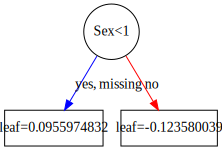

In [21]:
my_model = get_model_metrics_and_display(train_data,X_columns=['Sex'])
xgb.to_graphviz(my_model)


How do we interpret these numbers and convert to probabilities ?

Check out the following links in detail : https://github.com/dmlc/xgboost/issues/1746
https://stackoverflow.com/questions/39858916/xgboost-how-to-get-probabilities-of-class-from-xgb-dump-multisoftprob-objecti

#### Fine tuning using xgboost cross validation

In [22]:
X_train = train_data[X_columns]
Y_train = train_data[Y_columns]
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
params = {"Objective" : 'gbtree',
          "eval_metric" : 'error',
          'learning_rate' : 0.05
         }
cv = xgb.cv(dtrain=dtrain, params=params, num_boost_round=500, nfold=5, seed=0, early_stopping_rounds=10)

In [23]:
cv.tail(10)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.213244,0.009413,0.213244,0.00235


#### Fine tuning using GridSearchCV

In [24]:
searchCV = get_gridsearch_crossval_output(train_data, X_columns=X_columns)
searchCV.best_params_


{'xgcl__learning_rate': 0.01, 'xgcl__n_estimators': 10}

In [25]:
searchCV.cv_results_['mean_train_score']

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([0.78892366, 0.78892366, 0.78892366, 0.78892366, 0.78892366,
       0.78892366, 0.78892366, 0.78892366, 0.78892366, 0.78892366,
       0.78892366, 0.78892366, 0.78892366, 0.78892366, 0.78892366,
       0.78892366, 0.78892366, 0.78892366, 0.78892366, 0.78892366,
       0.78892366, 0.78892366, 0.78892366, 0.78892366, 0.78892366,
       0.78892366, 0.78892366, 0.78892366, 0.78892366, 0.78892366,
       0.78892366, 0.78892366, 0.78892366, 0.78892366, 0.78892366])

In [26]:
searchCV.cv_results_['mean_test_score']

array([0.78892216, 0.78892216, 0.78892216, 0.78892216, 0.78892216,
       0.78892216, 0.78892216, 0.78892216, 0.78892216, 0.78892216,
       0.78892216, 0.78892216, 0.78892216, 0.78892216, 0.78892216,
       0.78892216, 0.78892216, 0.78892216, 0.78892216, 0.78892216,
       0.78892216, 0.78892216, 0.78892216, 0.78892216, 0.78892216,
       0.78892216, 0.78892216, 0.78892216, 0.78892216, 0.78892216,
       0.78892216, 0.78892216, 0.78892216, 0.78892216, 0.78892216])

### Model 2: Sex and Pclass as predictors.

#### Basic training/cross validation

In [27]:
X_columns = ['Sex', 'Pclass']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 527
Number of entries in test set is 223
Number of correct predictions in test set is 174
Out of sample score is 0.7802690582959642
Cross val score is 0.7733072037001376


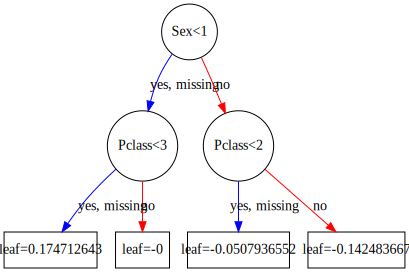

In [28]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


It looks like here, we are not taking into account pclass here. Hence, let us see if we can finetune the model to take into account plcass as well.

#### Fine tuning using xgboost cross validation

In [29]:
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
params = {"Objective" : 'gbtree',
          "eval_metric" : 'error',
          'learning_rate' : 0.05
         }
cv = xgb.cv(dtrain=dtrain, params=params, num_boost_round=500, nfold=5, seed=0, early_stopping_rounds=10)

In [30]:
cv.tail(10)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.213244,0.009413,0.213244,0.00235


#### Fine tuning using GridSearchCV

In [31]:
searchCV = get_gridsearch_crossval_output(train_data, X_columns=X_columns)
searchCV.best_params_


{'xgcl__learning_rate': 0.01, 'xgcl__n_estimators': 10}

In [32]:
searchCV.cv_results_['mean_train_score']

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([0.79041899, 0.79041899, 0.79041899, 0.79041899, 0.79041899,
       0.79041899, 0.79041899, 0.79041899, 0.79041899, 0.79041899,
       0.79041899, 0.79041899, 0.79041899, 0.79041899, 0.79041899,
       0.79041899, 0.79041899, 0.79041899, 0.79041899, 0.79041899,
       0.79041899, 0.79041899, 0.79041899, 0.79041899, 0.79041899,
       0.79041899, 0.79041899, 0.79041899, 0.79041899, 0.79041899,
       0.79041899, 0.79041899, 0.79041899, 0.79041899, 0.79041899])

In [33]:
searchCV.cv_results_['mean_test_score']

array([0.77095808, 0.77095808, 0.77095808, 0.77095808, 0.77095808,
       0.77095808, 0.77095808, 0.77095808, 0.77095808, 0.77095808,
       0.77095808, 0.77095808, 0.77095808, 0.77095808, 0.77095808,
       0.77095808, 0.77095808, 0.77095808, 0.77095808, 0.77095808,
       0.77095808, 0.77095808, 0.77095808, 0.77095808, 0.77095808,
       0.77095808, 0.77095808, 0.77095808, 0.77095808, 0.77095808,
       0.77095808, 0.77095808, 0.77095808, 0.77095808, 0.77095808])

### Model 3: Sex, Pclass  and Age as predictors.

#### Basic training/cross validation

In [34]:
X_columns = ['Sex', 'Pclass', 'Age']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 562
Number of entries in test set is 223
Number of correct predictions in test set is 184
Out of sample score is 0.8251121076233183
Cross val score is 0.8025148353403998


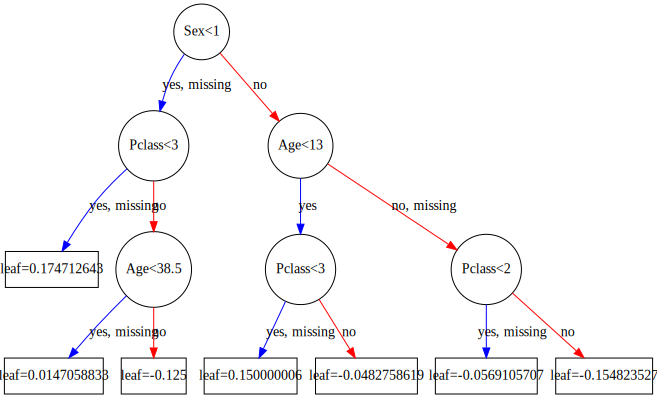

In [35]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


#### Fine tuning using xgboost cross validation

In [36]:
X_train = train_data[X_columns]
Y_train = train_data[Y_columns]
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
params = {"Objective" : 'gbtree',
          "eval_metric" : 'error',
          'learning_rate' : 0.05
         }
cv = xgb.cv(dtrain=dtrain, params=params, num_boost_round=500, nfold=5, seed=0, early_stopping_rounds=10)

In [37]:
cv.tail(10)

,test-error-mean,test-error-std,train-error-mean,train-error-std
9,0.197552,0.024095,0.139734,0.008402
10,0.197552,0.024095,0.138892,0.008791
11,0.197552,0.024095,0.138892,0.008791
12,0.198675,0.026163,0.138612,0.008987
13,0.197552,0.024095,0.138050,0.008302
14,0.198675,0.026163,0.137769,0.008527
15,0.198675,0.026163,0.137489,0.008693
16,0.198675,0.026163,0.137489,0.008693
17,0.197552,0.024095,0.137769,0.008481
18,0.196428,0.028547,0.136928,0.008018


#### Fine tuning using GridSearchCV

In [38]:
searchCV = get_gridsearch_crossval_output(train_data, X_columns=X_columns,
                                          Y_columns = ['Survived'],
                                          n_estimators_list = [10, 15, 18, 20, 50, 70, 100, 120, 150, 200])
searchCV.best_params_


{'xgcl__learning_rate': 0.05, 'xgcl__n_estimators': 15}

In [39]:
searchCV.cv_results_['mean_train_score']

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([0.81624278, 0.81624278, 0.81624278, 0.81624278, 0.81624278,
       0.81624278, 0.81624278, 0.81624278, 0.81624278, 0.81624278,
       0.81624278, 0.81624278, 0.81624278, 0.81624278, 0.81624278,
       0.81624278, 0.81624278, 0.81624278, 0.81624278, 0.81624278,
       0.81661731, 0.81661731, 0.81661731, 0.81661731, 0.81661731,
       0.81661731, 0.81661731, 0.81661731, 0.81661731, 0.81661731,
       0.81699184, 0.81661731, 0.81661731, 0.81661731, 0.81661731,
       0.81661731, 0.81661731, 0.81661731, 0.81661731, 0.81661731,
       0.81773951, 0.81773951, 0.81773951, 0.81773951, 0.81773951,
       0.81773951, 0.81773951, 0.81773951, 0.81773951, 0.81773951])

In [40]:
searchCV.cv_results_['mean_test_score']

array([0.80988024, 0.80988024, 0.80988024, 0.80988024, 0.80988024,
       0.80988024, 0.80988024, 0.80988024, 0.80988024, 0.80988024,
       0.80988024, 0.80988024, 0.80988024, 0.80988024, 0.80988024,
       0.80988024, 0.80988024, 0.80988024, 0.80988024, 0.80988024,
       0.81137725, 0.81287425, 0.81287425, 0.81287425, 0.81287425,
       0.81287425, 0.81287425, 0.81287425, 0.81287425, 0.81287425,
       0.81287425, 0.81287425, 0.81287425, 0.81287425, 0.81287425,
       0.81287425, 0.81287425, 0.81287425, 0.81287425, 0.81287425,
       0.8008982 , 0.8008982 , 0.8008982 , 0.8008982 , 0.8008982 ,
       0.8008982 , 0.8008982 , 0.8008982 , 0.8008982 , 0.8008982 ])

In [41]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data,
                              X_columns, 
                              Y_columns,
                              n_estimators=15,
                              learning_rate=0.05)
    
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 668
Number of correct predictions in training set is 545
Number of entries in test set is 223
Number of correct predictions in test set is 178
Out of sample score is 0.7982062780269058
Cross val score is 0.7857111193150405


Question : Why is the optimal choice for n_estimators and learning_rate returning sub optimal results when we run with our manual cross validation procedure ?

In [42]:
#create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)
X_columns = ['Sex']
Y_column = ['Survived']
X_train = train_data[X_columns]
X_train_one_hot = pd.get_dummies(X_train)
Y_train = train_data[Y_column]
X_test = test_data[X_columns]
X_test_one_hot = pd.get_dummies(X_test)
Y_test = test_data[Y_column]
(my_pipeline, out_of_sample_score, predictions_out_of_sample) = \
    create_pipeline_and_out_of_sample_score(X_train_one_hot, 
                                            X_test_one_hot,
                                            Y_train,
                                            Y_test,
                                            50,
                                            0.01)
print("Complete score on out of sample data is {0}".format(out_of_sample_score))
test_data['Predictions'] = predictions_out_of_sample
kaggle_data = test_data[['PassengerId', 'Predictions']].copy()
kaggle_data.rename(columns={'Predictions' : 'Survived'}, inplace=True)
kaggle_data.sort_values(by=['PassengerId']).to_csv('kaggle_out_xgboost_sex_only.csv', index=False)

Complete score on out of sample data is 0.7655502392344498


Question : We really do not look to be getting any benefit from the addition of Age and Pclass variables. Why is that the case ?

### Model 4: Sex, Pclass,Age,Fare as predictors.

In [43]:
X_columns = ['Sex', 'Pclass', 'Age', 'Fare']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 576
Number of entries in test set is 223
Number of correct predictions in test set is 186
Out of sample score is 0.8340807174887892
Cross val score is 0.8305672733436958


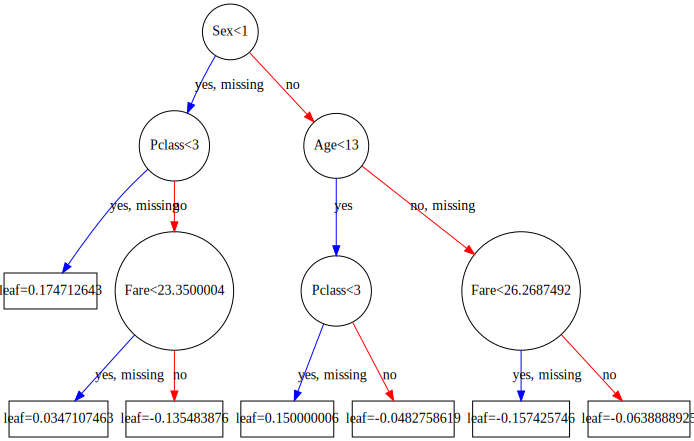

In [44]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


#### Fine tuning using cross validation

In [45]:
X_train = train_data[X_columns]
Y_train = train_data[Y_columns]
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
params = {"Objective" : 'gbtree',
          "eval_metric" : 'error',
          'learning_rate' : 0.01
         }
cv = xgb.cv(dtrain=dtrain, params=params, num_boost_round=500, nfold=5, seed=0, early_stopping_rounds=10)

In [46]:
cv.tail(10)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.191946,0.027087,0.131874,0.002643
1,0.189699,0.024371,0.129630,0.003032


#### Fine tuning using grid searchCV

In [47]:
searchCV = get_gridsearch_crossval_output(train_data, X_columns=X_columns,
                                          Y_columns = ['Survived'],
                                          n_estimators_list = [1, 2, 3, 4 , 5, 6 ,7 ,8 , 10, 15, 18, 20, 50, 70, 100, 120, 150, 200])
searchCV.best_params_


{'xgcl__learning_rate': 0.01, 'xgcl__n_estimators': 1}

In [48]:
searchCV.cv_results_['mean_test_score']

array([0.81287425, 0.81287425, 0.80538922, 0.80538922, 0.80538922,
       0.80988024, 0.80988024, 0.80988024, 0.80988024, 0.81137725,
       0.81137725, 0.81137725, 0.81137725, 0.81137725, 0.81137725,
       0.81137725, 0.81137725, 0.81137725, 0.81287425, 0.81287425,
       0.80538922, 0.80988024, 0.80988024, 0.80988024, 0.81137725,
       0.81137725, 0.81137725, 0.81137725, 0.81137725, 0.81137725,
       0.81137725, 0.81137725, 0.81137725, 0.81137725, 0.81137725,
       0.81137725, 0.81287425, 0.81287425, 0.80988024, 0.80988024,
       0.81137725, 0.81137725, 0.81137725, 0.81137725, 0.81137725,
       0.81137725, 0.81137725, 0.81137725, 0.81137725, 0.81137725,
       0.81137725, 0.81137725, 0.81137725, 0.81137725, 0.81287425,
       0.80988024, 0.81137725, 0.81137725, 0.81137725, 0.81137725,
       0.81137725, 0.81137725, 0.81137725, 0.81137725, 0.81137725,
       0.81137725, 0.81137725, 0.81137725, 0.81137725, 0.81137725,
       0.81137725, 0.81137725, 0.81287425, 0.80988024, 0.81137

In [49]:
searchCV.cv_results_['mean_train_score']

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([0.82971613, 0.82971613, 0.82896706, 0.82896706, 0.82896706,
       0.82934159, 0.82934159, 0.83196332, 0.83196332, 0.82971613,
       0.82971613, 0.82971613, 0.82971613, 0.82971613, 0.82971613,
       0.82971613, 0.82971613, 0.82971613, 0.82971613, 0.82971613,
       0.82896706, 0.82934159, 0.83196332, 0.83196332, 0.82971613,
       0.82971613, 0.82971613, 0.82971613, 0.82971613, 0.82971613,
       0.82971613, 0.82971613, 0.82971613, 0.82971613, 0.82971613,
       0.82971613, 0.82971613, 0.82971613, 0.82934159, 0.83196332,
       0.82971613, 0.83009066, 0.83121215, 0.83009066, 0.83121215,
       0.83121215, 0.83121215, 0.83121215, 0.83121215, 0.83121215,
       0.83121215, 0.83121215, 0.83121215, 0.83121215, 0.82971613,
       0.83196332, 0.82971613, 0.82971613, 0.83009066, 0.83121215,
       0.83121215, 0.83121215, 0.83158668, 0.83121215, 0.83121215,
       0.83121215, 0.83121215, 0.83121215, 0.83121215, 0.83121215,
       0.83121215, 0.83121215, 0.82971613, 0.83196332, 0.83121

In [50]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data,
                              X_columns,  
                              Y_columns,
                              n_estimators=1,
                              learning_rate=0.01)
    
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 668
Number of correct predictions in training set is 554
Number of entries in test set is 223
Number of correct predictions in test set is 180
Out of sample score is 0.8071748878923767
Cross val score is 0.8091998438179905


In [51]:
#create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)
X_train = train_data[X_columns]
X_train_one_hot = pd.get_dummies(X_train)
Y_train = train_data[Y_column]
X_test = test_data[X_columns]
X_test_one_hot = pd.get_dummies(X_test)
Y_test = test_data[Y_column]
(my_pipeline, out_of_sample_score, predictions_out_of_sample) = \
    create_pipeline_and_out_of_sample_score(X_train_one_hot, 
                                            X_test_one_hot,
                                            Y_train,
                                            Y_test,
                                            1,
                                            0.01)
print("Complete score on out of sample data is {0}".format(out_of_sample_score))
test_data['Predictions'] = predictions_out_of_sample
kaggle_data = test_data[['PassengerId', 'Predictions']].copy()
kaggle_data.rename(columns={'Predictions' : 'Survived'}, inplace=True)
kaggle_data.sort_values(by=['PassengerId']).to_csv('kaggle_out_xgboost_sex_pclass_age_fare.csv', index=False)

Complete score on out of sample data is 0.7870813397129186


In [52]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Predictions'],
      dtype='object')

In [53]:
train_data[train_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predictions
61,62,1,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B28,NaN,-1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B28,NaN,-1


We do some plots if we can include Embarked variable and make some sense .

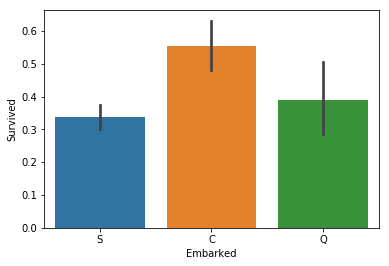

In [54]:
sns.barplot(x='Embarked', y='Survived', data=train_data[train_data['Embarked'].notnull()])

Comments : The port 'C' looks to be having a bigger survival rate. Now, let us see if that is explained by the gender variable (putting in other words, we want to see if the bigger survival rate is explained by more females boarding from this point).

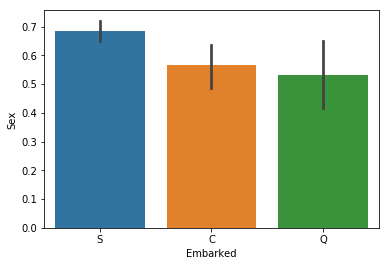

In [55]:
sns.barplot(x='Embarked', y='Sex', data=train_data[train_data['Embarked'].notnull()])

Comment : It does look like more number of males boarded from 'S' than from 'C' or 'Q', even though the number of males were roughly same across 'C' and 'Q'. 

This definitely had an effect, though I am not sure if this could explain it completely.

Now, let us see if the passengers from 'C' were predominantly from a higher class and whether that explains the survival rate.

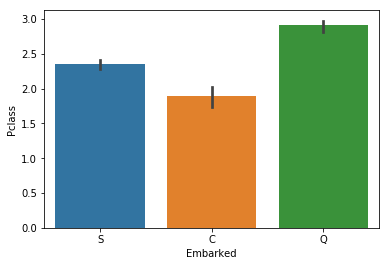

In [56]:
sns.barplot(x='Embarked', y='Pclass', data=train_data[train_data['Embarked'].notnull()])

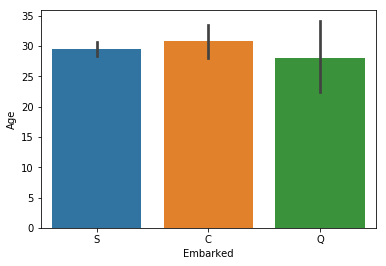

In [57]:
sns.barplot(x='Embarked', y='Age', data=train_data[train_data['Embarked'].notnull()])

Comments : It is quite visible that the average class of people boaridng from 'C' is less compared to that of 'Q' or 'S', implying that we had a higher percentage of higher class people and this definitely played a part in getting a better survival rate.

We decide to do the following :

1. Include a new factor on whether the boarding point was 'C' or not. This way, we will be able to add this information without adding too many dimensions.


2. Make sure that we add factors Pclass and Sex when we test out the factor. This way, we will make sure that we do not see any false predictive power from this factor, which was already present in Sex and Pclass factors.

In [58]:
train_data['boarded_from_C'] = 0
test_data['boarded_from_C'] = 0

In [59]:
train_data.loc[(train_data['Embarked'] == 'C'), 'boarded_from_C'] = 1
test_data.loc[(test_data['Embarked'] == 'C'), 'boarded_from_C'] = 1

### Model 5: Sex, Pclass,Age,Fare,boarded_from_C as predictors.

In [60]:
X_columns = ['Sex', 'Pclass', 'Age', 'Fare', 'boarded_from_C']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 585
Number of entries in test set is 223
Number of correct predictions in test set is 188
Out of sample score is 0.8430493273542601
Cross val score is 0.8216036175782071


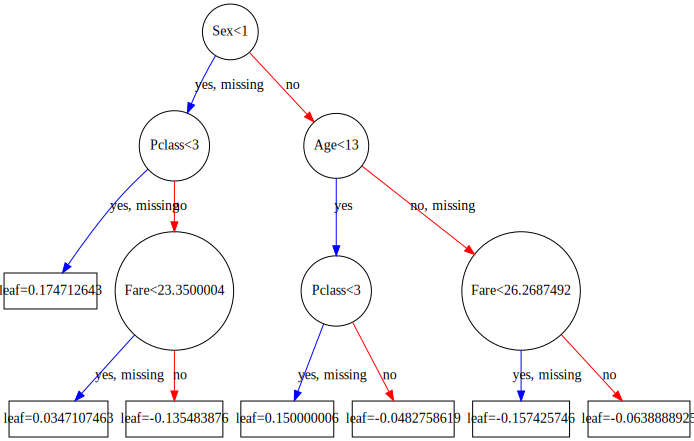

In [61]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


Comments : 

1. The cross validation score looks to have decreaesed.
2. Though, we see a different cross validation score, the printed model looks identical to that of the earlier one.

For the sake of completeness, I am going over the cross validation procedure as well here.

In [62]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Predictions',
       'boarded_from_C'],
      dtype='object')

### Yet another approach.

Now, we try another approach, wherein we try to build another miniscule model using other features and then later do an ensemble with the models already built by us.

### Model 1: Age as the only predictor

In [63]:
X_columns = ['Age']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 440
Number of entries in test set is 223
Number of correct predictions in test set is 140
Out of sample score is 0.6278026905829597
Cross val score is 0.6341616937733241


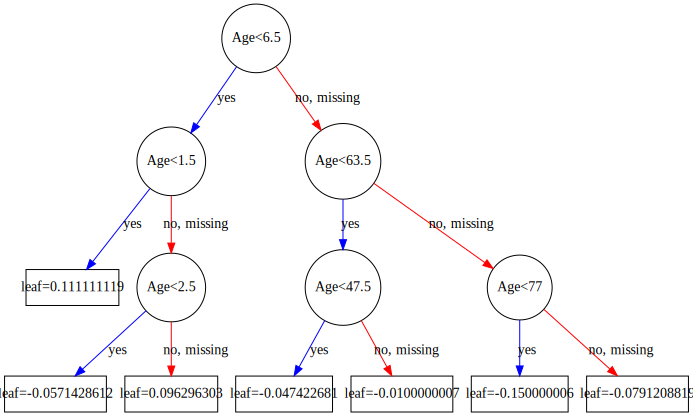

In [64]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


Comments : As expected the stats are very bad. Now, let us see if we can add the boarding information and see if things improve.

### Model 2: Age, boarded_from_C as the only predictor

In [65]:
X_columns = ['Age', 'boarded_from_C']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 454
Number of entries in test set is 223
Number of correct predictions in test set is 147
Out of sample score is 0.663677130044843
Cross val score is 0.6476514006199758


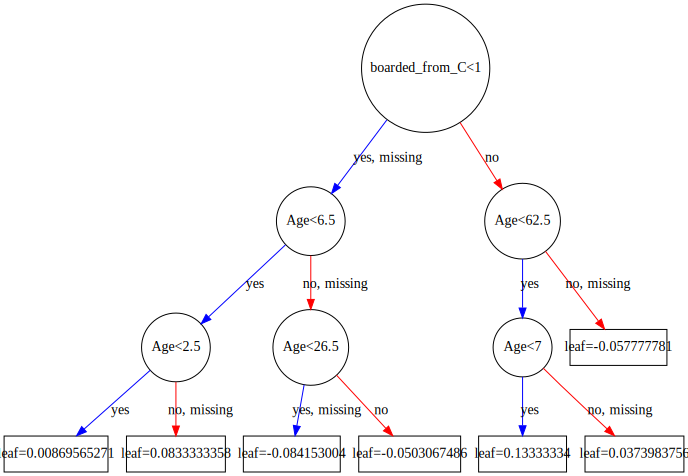

In [66]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


Comments : As expected , stats do not come up significantly even now. Let us try adding Pclass

### Model 3: Age, boarded_from_C,Pclass as the only predictor

In [67]:
X_columns = ['Age', 'Pclass', 'boarded_from_C']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 488
Number of entries in test set is 223
Number of correct predictions in test set is 165
Out of sample score is 0.7443946188340806
Cross val score is 0.6914342466292667


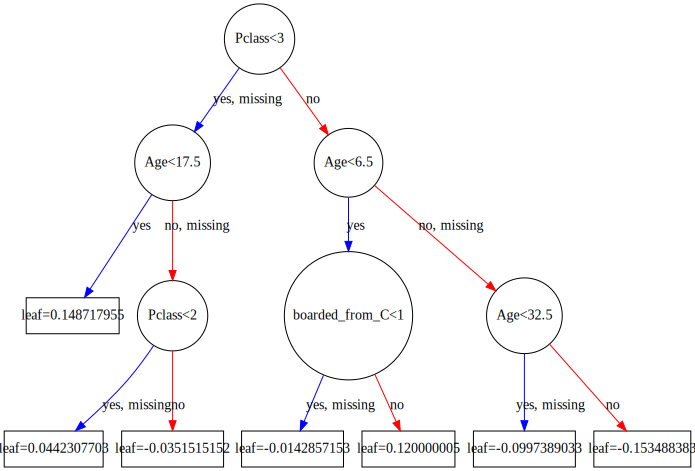

In [68]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


Comments : As expected the performance has gone up considerably. The field boarded_from_C does not look to be helping much. Let us remove the same.

### Model 4: Age,Pclass as the only predictor

In [69]:
X_columns = ['Age', 'Pclass']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 481
Number of entries in test set is 223
Number of correct predictions in test set is 168
Out of sample score is 0.7533632286995515
Cross val score is 0.6947924790063931


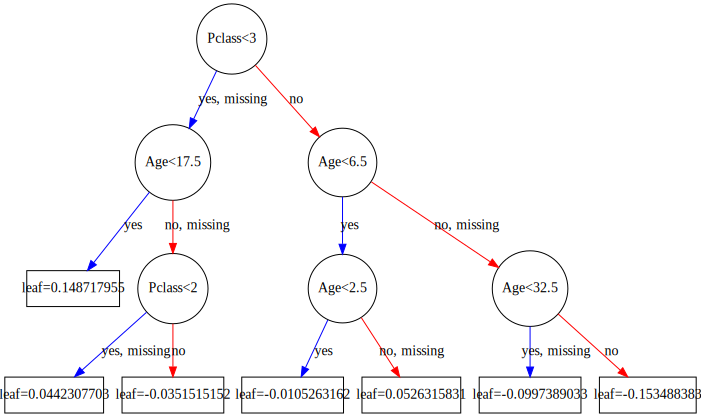

In [70]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


Comments : As expected, we do not look to be gaining much from the boarding variable. Let us add Fare and see how it looks.

### Model 5: Age,Pclass,Fare as the only predictor

In [71]:
X_columns = ['Age', 'Pclass', 'Fare']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 517
Number of entries in test set is 223
Number of correct predictions in test set is 170
Out of sample score is 0.7623318385650224
Cross val score is 0.7128650142723546


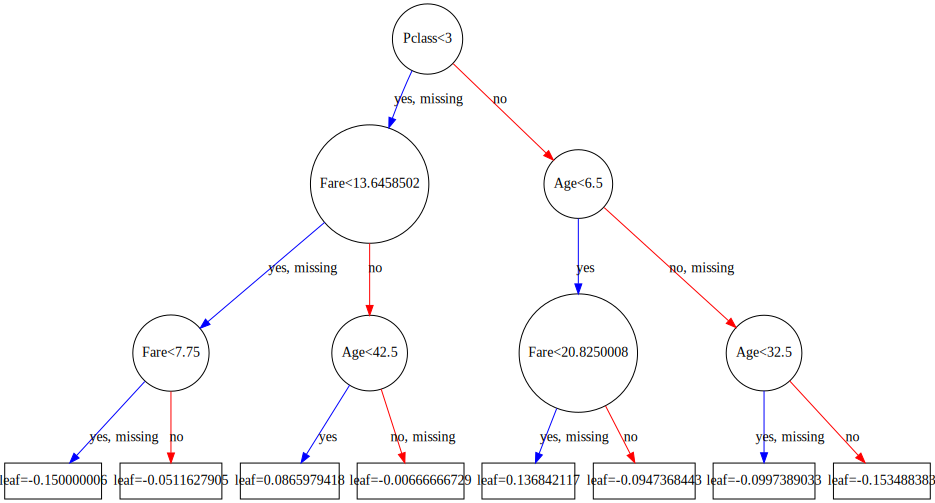

In [72]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


Comments : There is non trivial improvement in the cross validation score and hence we decide to keep fare variable.

Now, let us try to make sense of sibling and parch variables. Since, these roughly correspond to number of family members, let us try adding sum of these as another variable.

### Model 6: Age,Pclass,Fare,SibSp + Parch as the only predictor

In [73]:
train_data['FamilyNum'] = train_data['SibSp'] + train_data['Parch']

In [74]:
X_columns = ['Age', 'Pclass', 'Fare', 'FamilyNum']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 516
Number of entries in test set is 223
Number of correct predictions in test set is 170
Out of sample score is 0.7623318385650224
Cross val score is 0.710567322992836


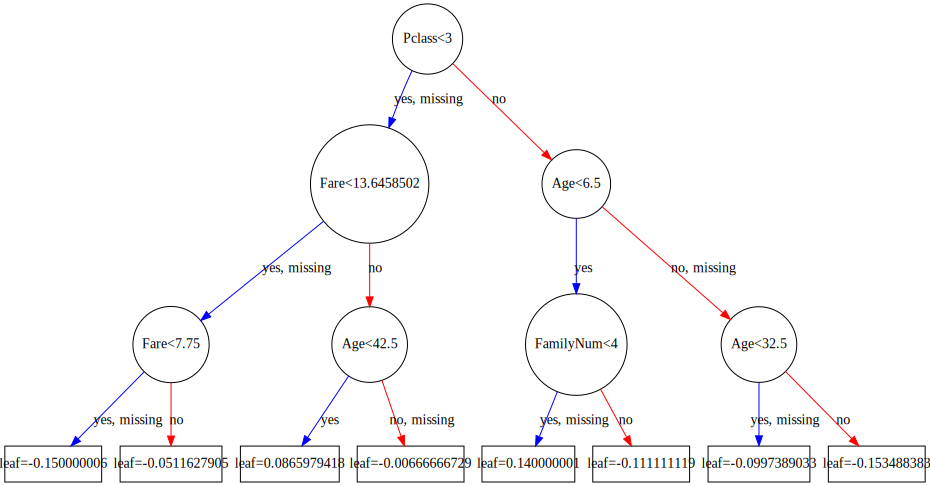

In [75]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


Comment : We do not see much of benefit here and hence we do not add this indicator.

Hence, we finalize on this model and try to solve for most optimal tuning parameters.

In [76]:
X_columns = ['Age', 'Pclass', 'Fare']
Y_columns = ['Survived']

#### Fine tuning using cross validation

In [77]:
X_train = train_data[X_columns]
Y_train = train_data[Y_columns]
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
params = {"Objective" : 'gbtree',
          "eval_metric" : 'error',
          'learning_rate' : 0.05
         }
cv = xgb.cv(dtrain=dtrain, params=params, num_boost_round=500, nfold=5, seed=0, early_stopping_rounds=10)

In [78]:
cv.tail(10)

,test-error-mean,test-error-std,train-error-mean,train-error-std
7,0.291853,0.030727,0.206510,0.011268
8,0.298588,0.032619,0.205950,0.012133
9,0.291846,0.024762,0.205388,0.010026
10,0.290716,0.021813,0.207351,0.011060
11,0.289593,0.022982,0.207071,0.011805
12,0.289593,0.021855,0.205387,0.012467
13,0.287358,0.025863,0.199493,0.011094
14,0.285111,0.028176,0.198371,0.009544
15,0.287346,0.024237,0.196687,0.009661
16,0.281734,0.025746,0.195003,0.011691


#### Fine tuning using grid searchCV

In [79]:
searchCV = get_gridsearch_crossval_output(train_data, X_columns=X_columns,
                                          n_estimators_list = [1, 2, 3, 4 , 5, 6 ,7 ,8 , 9, 10, 11, 12, 13, 14, 15, 16,  18, 20, 39, 40, 41, 42],
                                          learning_rates_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07])
searchCV.best_params_


{'xgcl__learning_rate': 0.05, 'xgcl__n_estimators': 5}

Comment : It is sort of strange as to why these 2 methods do not agree much. Anyways, let us move on !

In [80]:
searchCV.cv_results_['mean_test_score']

array([0.71107784, 0.71107784, 0.71107784, 0.71257485, 0.71257485,
       0.71257485, 0.71257485, 0.71257485, 0.71257485, 0.71257485,
       0.71257485, 0.71257485, 0.71257485, 0.71257485, 0.71257485,
       0.71257485, 0.71257485, 0.71257485, 0.71257485, 0.71257485,
       0.71257485, 0.71257485, 0.71107784, 0.71257485, 0.71257485,
       0.71257485, 0.71257485, 0.71257485, 0.71257485, 0.71407186,
       0.71407186, 0.71407186, 0.71407186, 0.71407186, 0.71407186,
       0.71407186, 0.71407186, 0.71407186, 0.71407186, 0.71407186,
       0.71407186, 0.71407186, 0.71407186, 0.71407186, 0.71107784,
       0.71257485, 0.71257485, 0.71257485, 0.71407186, 0.71407186,
       0.71407186, 0.71407186, 0.71407186, 0.71407186, 0.71257485,
       0.71257485, 0.70958084, 0.71107784, 0.70958084, 0.70958084,
       0.70958084, 0.70958084, 0.70958084, 0.70958084, 0.70958084,
       0.70958084, 0.71107784, 0.71257485, 0.71257485, 0.71407186,
       0.71407186, 0.71407186, 0.71107784, 0.71407186, 0.70958

In [81]:
searchCV.cv_results_['mean_train_score']

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([0.71481746, 0.71631559, 0.71631559, 0.71893731, 0.71893731,
       0.71893731, 0.71893731, 0.71893731, 0.71893731, 0.71893731,
       0.71893731, 0.71893731, 0.71893731, 0.71893731, 0.71893731,
       0.71893731, 0.71893731, 0.71893731, 0.71893731, 0.71893731,
       0.71893731, 0.71893731, 0.71481746, 0.71893731, 0.71893731,
       0.71893731, 0.71893731, 0.71893731, 0.71893731, 0.71968637,
       0.71968637, 0.71968637, 0.71968637, 0.71968637, 0.71968637,
       0.71968637, 0.71968637, 0.71968637, 0.71968637, 0.71968637,
       0.71968637, 0.71968637, 0.71968637, 0.71968637, 0.71481746,
       0.71893731, 0.71893731, 0.71893731, 0.71968637, 0.71968637,
       0.71968637, 0.71968637, 0.71968637, 0.71968637, 0.72006091,
       0.72006091, 0.71968637, 0.71968637, 0.71968637, 0.71968637,
       0.71968637, 0.71968637, 0.71968637, 0.71968637, 0.71968637,
       0.71968637, 0.71481746, 0.71893731, 0.71893731, 0.71968637,
       0.71968637, 0.71968637, 0.72267703, 0.71968637, 0.72305

In [82]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data,
                              X_columns,  
                              Y_columns,
                              n_estimators=5,
                              learning_rate=0.05)
    
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 668
Number of correct predictions in training set is 477
Number of entries in test set is 223
Number of correct predictions in test set is 163
Out of sample score is 0.7309417040358744
Cross val score is 0.7094689066940163


Comments : The mystery continues as to why we do not see good results with our cross validation procedure !

In [83]:
#create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)
X_train = train_data[X_columns]
X_train_one_hot = pd.get_dummies(X_train)
Y_train = train_data[Y_column]
X_test = test_data[X_columns]
X_test_one_hot = pd.get_dummies(X_test)
Y_test = test_data[Y_column]
(my_pipeline, out_of_sample_score, predictions_out_of_sample) = \
    create_pipeline_and_out_of_sample_score(X_train_one_hot, 
                                            X_test_one_hot,
                                            Y_train,
                                            Y_test,
                                            50,
                                            0.05)
print("Complete score on out of sample data is {0}".format(out_of_sample_score))
test_data['Predictions'] = predictions_out_of_sample
kaggle_data = test_data[['PassengerId', 'Predictions']].copy()
kaggle_data.rename(columns={'Predictions' : 'Survived'}, inplace=True)
kaggle_data.sort_values(by=['PassengerId']).to_csv('kaggle_out_xgboost_no_sex.csv', index=False)

Complete score on out of sample data is 0.6602870813397129


Comment : The performance is disappointing, but frankly not much unexpected, given that we did not have the gender variable, which is immensely important.

This shows that we cannot simply pick up models, which are to be ensembled, but need to build reasonably stronger models first (the strength of the ensemble is only as much as the strength of it's constituents).

Let us try to build a model avoiding Pclass variable.

In [84]:
X_columns = ['Sex', 'Age', 'Fare']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 571
Number of entries in test set is 223
Number of correct predictions in test set is 182
Out of sample score is 0.8161434977578476
Cross val score is 0.7990810653428787


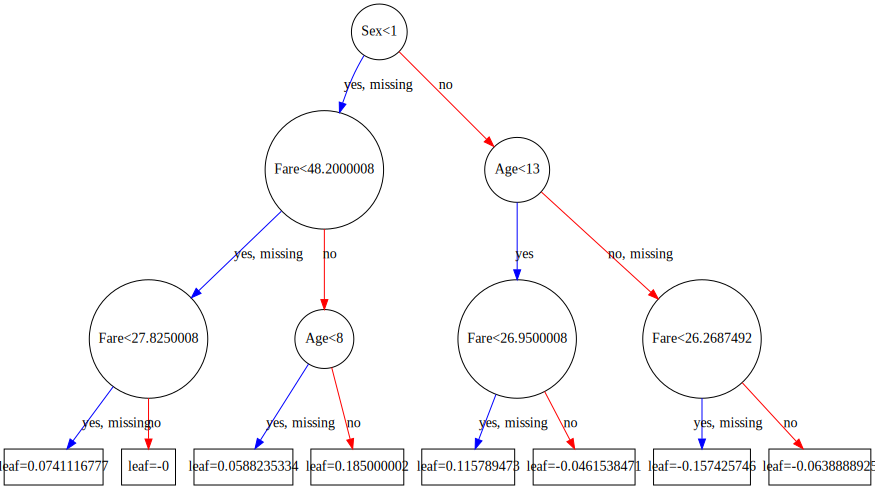

In [85]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


Comments : This results do not look bad. Let us fine tune our parameters and see where we get !

In [86]:
X_train = train_data[X_columns]
Y_train = train_data[Y_columns]
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
params = {"Objective" : 'gbtree',
          "eval_metric" : 'error',
          'learning_rate' : 0.05
         }
cv = xgb.cv(dtrain=dtrain, params=params, num_boost_round=500, nfold=5, seed=0, early_stopping_rounds=10)

In [87]:
cv.tail(10)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.203138,0.012934,0.147588,0.010152


In [88]:
searchCV = get_gridsearch_crossval_output(train_data, X_columns=X_columns,
                                          n_estimators_list = [1, 2, 3, 4 , 5, 6 ,7 ,8 , 9, 10, 11, 12, 13, 14, 15, 16,  18, 20, 39, 40, 41, 42],
                                          learning_rates_list = [0.01, 0.02, 0.03, 0.04, 0.05,  0.06, 0.07])
searchCV.best_params_


{'xgcl__learning_rate': 0.05, 'xgcl__n_estimators': 10}

In [89]:
#create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)
X_train = train_data[X_columns]
X_train_one_hot = pd.get_dummies(X_train)
Y_train = train_data[Y_column]
X_test = test_data[X_columns]
X_test_one_hot = pd.get_dummies(X_test)
Y_test = test_data[Y_column]
(my_pipeline, out_of_sample_score, predictions_out_of_sample) = \
    create_pipeline_and_out_of_sample_score(X_train_one_hot, 
                                            X_test_one_hot,
                                            Y_train,
                                            Y_test,
                                            10,
                                            0.02)
print("Complete score on out of sample data is {0}".format(out_of_sample_score))
test_data['Predictions'] = predictions_out_of_sample
kaggle_data = test_data[['PassengerId', 'Predictions']].copy()
kaggle_data.rename(columns={'Predictions' : 'Survived'}, inplace=True)
kaggle_data.sort_values(by=['PassengerId']).to_csv('kaggle_out_xgboost_no_pclass.csv', index=False)

Complete score on out of sample data is 0.7607655502392344


## Conclusion

We see that trying out models without sex variable and addition  of Embarked variable has not helped much. Hence, we conclude that the best model which we have been able to build (as part of this exercise) is the model with Sex, Age, Pclass and Fare as it's predictors.

Output Model => With predictors Sex, Age, Pclass, FAre

### Another model using Parch,SibSp,Fare

We are building another model using Parch,SibSp and Fare. Though this model, may not be very useful in itself, the very fact that we are using predictors, not used in other models, can help us yield a model not much correlated with others and can hence help in ensembling.


In [90]:
#create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)
X_columns = ['Parch', 'SibSp', 'Fare']
X_train = train_data[X_columns]
X_train_one_hot = pd.get_dummies(X_train)
Y_train = train_data[Y_column]
X_test = test_data[X_columns]
X_test_one_hot = pd.get_dummies(X_test)
Y_test = test_data[Y_column]
(my_pipeline, out_of_sample_score, predictions_out_of_sample) = \
    create_pipeline_and_out_of_sample_score(X_train_one_hot, 
                                            X_test_one_hot,
                                            Y_train,
                                            Y_test)
print("Complete score on out of sample data is {0}".format(out_of_sample_score))
test_data['Predictions'] = predictions_out_of_sample
kaggle_data = test_data[['PassengerId', 'Predictions']].copy()
kaggle_data.rename(columns={'Predictions' : 'Survived'}, inplace=True)
kaggle_data.sort_values(by=['PassengerId']).to_csv('kaggle_out_xgboost_parch_sibsp_fare.csv', index=False)

Complete score on out of sample data is 0.6961722488038278
